# Linear Classifier of Math-operators
In this notebook we build the linear classifier for the mathematical operators.  
Its safe to say this is quite overfitted on the operators we are given, but we accept this as its works on the usecase.

In [1]:
import os
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from torchvision import transforms, utils
import torchvision.transforms.functional as TF
import warnings
warnings.filterwarnings('ignore')

In [3]:
class OperatorsDataset(Dataset):
    """ Custom Dataset for Operators"""
    
    def __init__(self, root_dir, csv_file, transform = None, grayscale = True):
        
        self.root_dir = root_dir
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform
        self.grayscale = grayscale
        
    def __len__(self):
        return self.dataframe.shape[0]
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx].path)
        image = Image.open(img_name)

        label = self.dataframe.loc[idx].label
        
        if self.transform:
            sample = self.transform(image)
        
        image = np.asarray(image)        
        if self.grayscale:
            image = rgb2gray(image)
            
        image = image.astype(np.float32)

        return (image, label)

dataset = OperatorsDataset("./data/operators", "./data/operators/datasheet.csv", 
                           transform = transforms.Compose([transforms.RandomRotation(90),
                                                           transforms.RandomPerspective(),
                                                           transforms.ToTensor()]))

In [4]:

def get_dataloaders(dataset,
        batch_size = 4,
        valid_size = 0.2,
        shuffle = True,
        random_seed = 1):

    num_train = len(dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler,
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=valid_sampler,
    )
    return train_loader, valid_loader

train_loader, valid_loader = get_dataloaders(dataset)



In [5]:
class OperatorNet(nn.Module):
    def __init__(self):
        """ Init """
        super().__init__()
        self.fc1 = nn.Linear(32*32, 100)
        self.fc2 = nn.Linear(100, 5)
        
    def forward(self, x):
        """ Forward pass """
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
    def predict(self, x):
        """ Returns softmaxed labels"""
        
        x = self.forward(x)
        return F.softmax(x)


In [6]:
def validate_on_dataloader(net, dataloader):
    """
    Returns accuracy on a given dataloader given net
    """
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():    
        for images, labels in dataloader:

            images.resize_(images.size()[0], 1024)

            output = net(images)
            predicted = (F.softmax(output).data).max(1)[1]
            correct += (labels == predicted).sum().item()
            total += labels.size(0)

    return 100*(correct/total)

In [7]:
net = OperatorNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.00005)

epochs = 100
eval_every = 10

for e in range(epochs): 
    running_loss = 0
    
    for images, labels in iter(train_loader):
        
        images.resize_(images.size()[0], 1024)
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if e % eval_every == 0:
        print("\n----------------------------------------")
        print("\nStarted on epoch {}".format(e))
        print("Loss on current epoch: {}".format(running_loss))
        
        accuracy_train = validate_on_dataloader(net, train_loader)
        print("Accuracy on train set {}".format(np.around(accuracy_train, 2)))
        
        accuracy_val = validate_on_dataloader(net, valid_loader)
        print("Accuracy on validation set {}".format(np.around(accuracy_val, 2)))
        print("----------------------------------------\n")
                
        


----------------------------------------

Started on epoch 0
Loss on current epoch: 443.7697374820709
Accuracy on train set 62.75
Accuracy on validation set 60.39
----------------------------------------


----------------------------------------

Started on epoch 10
Loss on current epoch: 146.30780578404665
Accuracy on train set 88.91
Accuracy on validation set 86.36
----------------------------------------


----------------------------------------

Started on epoch 20
Loss on current epoch: 90.05744987353683
Accuracy on train set 93.52
Accuracy on validation set 88.31
----------------------------------------


----------------------------------------

Started on epoch 30
Loss on current epoch: 62.75812986306846
Accuracy on train set 95.22
Accuracy on validation set 88.96
----------------------------------------


----------------------------------------

Started on epoch 40
Loss on current epoch: 46.279984782100655
Accuracy on train set 96.6
Accuracy on validation set 89.61
-------

In [8]:
torch.save(net.state_dict(), "./weights/acc_91_88.ckpt")

Label: Plus
Predicted: Plus


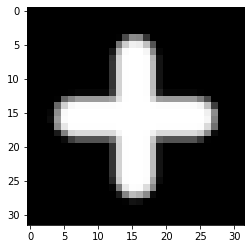

In [32]:
label_map = {0: "Plus", 1: "Minus", 2: "Multiplication", 3: "Divide", 4: "Equals"}

dataiter = iter(valid_loader)
images, labels = dataiter.next()
img_nr = np.random.randint(4, size = 1)
img, label = images[img_nr], labels[img_nr]

plt.imshow(img.resize(32,32), cmap = "Greys")
print('Label:', label_map[label.item()])

output = net(img.resize(1, 1024))
pred = (F.softmax(output).data).max(1)[1]
print('Predicted:', label_map[pred.item()])


In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Predicted: Plus


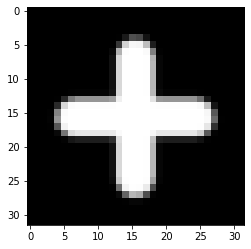

Predicted: Minus


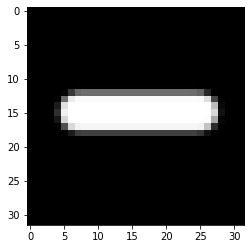

Predicted: Divide


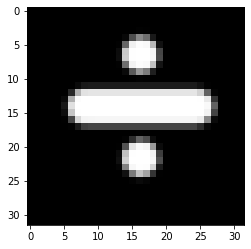

Predicted: Multiplication


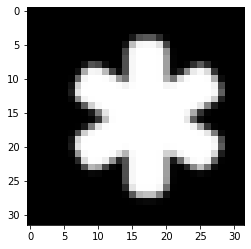

Predicted: Equals


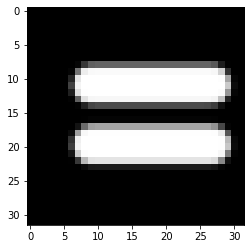

In [39]:
import time
from importlib import reload
from utils import get_operators_from_original
reload(utils)

op_tensors = get_operators_from_original()

for image in op_tensors:
    plt.imshow(image, cmap = "Greys")
    output = net(image.resize(1, 1024))
    pred = (F.softmax(output).data).max(1)[1]
    print('Predicted:', label_map[pred.item()])
    plt.show()
    time.sleep(1)